In [1]:
# Step 1: Install Required Libraries
#!python -m venv .venv
!pip install transformers datasets scikit-learn pandas tqdm -q
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu114
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platfo

In [2]:
# Step 2: Download and Extract the IMDb Dataset
import os
import tarfile
import urllib.request
import torch
from torch.utils.data import DataLoader

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"

if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()
    print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


In [3]:
# Step 3: Load and Format the Dataset into a Pandas DataFrame
import glob
import pandas as pd

def load_imdb_data(data_dir):
    def load_dir(path, label):
        texts = []
        for filepath in glob.glob(os.path.join(path, "*.txt")):
            with open(filepath, encoding='utf-8') as f:
                texts.append(f.read())
        return pd.DataFrame({"text": texts, "label": label})

    pos = load_dir(os.path.join(data_dir, "pos"), 1)
    neg = load_dir(os.path.join(data_dir, "neg"), 0)
    return pd.concat([pos, neg])

train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df


,text,label
0,I would just like all of the fans of this docu...,1
1,"""Cut"" is a film about some film students makin...",0
2,But this is a great martial arts film. Liu Chi...,1
3,It was 1 a.m. in the morning and I had nothing...,0
4,"Absolutely nothing happens in this sloooow, an...",0
...,...,...
24995,A huge hit upon release with Australian audien...,0
24996,Hard to imagine this film is based on a true s...,1
24997,A common plotline in films consists of the mai...,1
24998,First off - there's absolutely no flirting goi...,0


In [4]:
# Step 5: Tokenization using BERT
from transformers import BertTokenizer

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

#train_tokenized = train_dataset.map(tokenize, batched=True)
#test_tokenized = test_dataset.map(tokenize, batched=True)


In [5]:
# Step 4: Convert to HuggingFace Dataset Format
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model = model.to(device)
train_tokenized = train_dataset.map(tokenize, batched=True)
test_tokenized = test_dataset.map(tokenize, batched=True)

2025-04-21 13:35:50.601190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745242550.810235      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745242550.867794      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
# Step 6: Prepare Torch Datasets
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [8]:
# Step 7: Load BERT and Trainer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import accelerate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device:", device)

training_args = TrainingArguments(
    output_dir="./bert_results",

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=500
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
)


Training on device: cuda


/tmp/ipykernel_31/1191333040.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
# Step 8: Fine-Tune BERT
import wandb
wandb.login(key="8fa5eaba06a066d5e025308e320f58cdf64313d4")
trainer.train()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: paul-d10 (paul-d10-ensae-alumni) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
500,0.421200
1000,0.345600
1500,0.329600
2000,0.296500
2500,0.279800
3000,0.279300
3500,0.192300
4000,0.161500
4500,0.170000
5000,0.175100


TrainOutput(global_step=6250, training_loss=0.24141737060546875, metrics={'train_runtime': 1851.3236, 'train_samples_per_second': 27.008, 'train_steps_per_second': 3.376, 'total_flos': 6623369932800000.0, 'train_loss': 0.24141737060546875, 'epoch': 2.0})

In [10]:
# Save model after training
model_save_path = "./imdb_sentiment_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# Save training arguments using the to_json_string method instead
import json
with open(os.path.join(model_save_path, "training_args.json"), 'w') as f:
    json.dump(training_args.to_dict(), f)

print(f"Model saved to {model_save_path}")

Model saved to ./imdb_sentiment_model


In [11]:
# Step 9: Predict Scores for Test Set
from tqdm import tqdm

test_loader = DataLoader(test_tokenized, batch_size=16)
model.eval()

all_preds = []
all_scores = []
all_texts = test_df["text"].tolist()

with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'label'}
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_scores.extend(probs[:, 1].cpu().numpy())  # Positive score


100%|██████████| 1563/1563 [03:20<00:00,  7.81it/s]


In [12]:
# Step 10: Create Final Scored DataFrame
import numpy as np
scored_df = pd.DataFrame({
    "review": all_texts,
    "predicted_sentiment": all_preds,
    "positive_score": all_scores
})

scored_df.head()
scored_df.to_csv('predictions_results.csv',index=False)

np.save("labels.npy", np.array(all_preds))
np.save("scores.npy", np.array(all_scores))
print(f"Numpy arrays saved")


Numpy arrays saved


In [13]:
# Step 11: Evaluate the model on the test set
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(test_tokenized)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9314
Precision: 0.9296
Recall: 0.9334
F1 Score: 0.9315


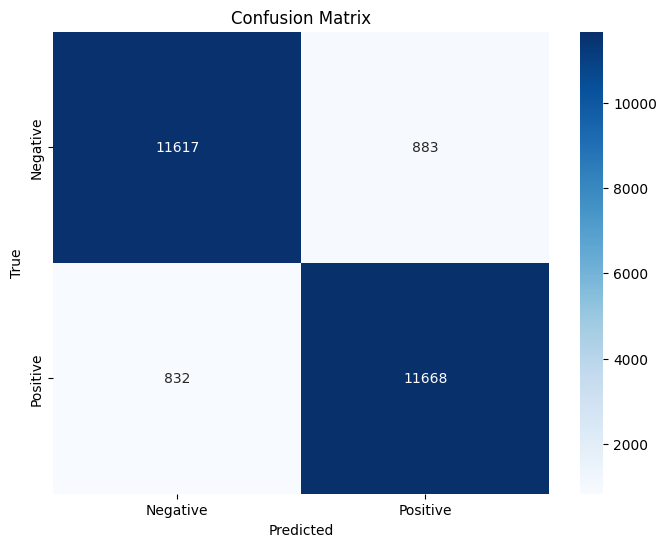

In [14]:
# Create confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Plot some example predictions
def show_example_predictions(dataset, predictions, num_examples=10):
    indices = np.random.choice(range(len(dataset)), num_examples, replace=False)
    for idx in indices:
        text = dataset[idx]['text']
        true_label = "Positive" if dataset[idx]['label'] == 1 else "Negative"
        pred_label = "Positive" if preds[idx] == 1 else "Negative"
        confidence = predictions.predictions[idx].max()

        print(f"Review: {text[:100]}...")
        print(f"True sentiment: {true_label}")
        print(f"Predicted sentiment: {pred_label}")
        print(f"Confidence: {confidence:.4f}")
        print("-" * 80)

# Show examples of correct and incorrect predictions
correct_indices = np.where(preds == labels)[0]
incorrect_indices = np.where(preds != labels)[0]

print("\n=== CORRECTLY CLASSIFIED EXAMPLES ===")
if len(correct_indices) > 0:
    correct_sample = np.random.choice(correct_indices, min(10, len(correct_indices)), replace=False)
    for idx in correct_sample:
        text = test_df.iloc[idx]['text']
        true_label = "Positive" if test_df.iloc[idx]['label'] == 1 else "Negative"
        pred_label = "Positive" if preds[idx] == 1 else "Negative"

        print(f"Review: {text[:150]}...")
        print(f"True sentiment: {true_label}")
        print(f"Predicted sentiment: {pred_label}")
        print(f"Confidence: {predictions.predictions[idx].max()}")
        print(f"Positive score : {all_scores[idx]}")
        print("-" * 80)

print("\n=== INCORRECTLY CLASSIFIED EXAMPLES ===")
if len(incorrect_indices) > 0:
    incorrect_sample = np.random.choice(incorrect_indices, min(10, len(incorrect_indices)), replace=False)
    for idx in incorrect_sample:
        text = test_df.iloc[idx]['text']
        true_label = "Positive" if test_df.iloc[idx]['label'] == 1 else "Negative"
        pred_label = "Positive" if preds[idx] == 1 else "Negative"

        print(f"Review: {text[:150]}...")
        print(f"True sentiment: {true_label}")
        print(f"Predicted sentiment: {pred_label}")
        print(f"Confidence: {predictions.predictions[idx].max()}")
        print(f"Positive score : {all_scores[idx]}")
        print("-" * 80)



=== CORRECTLY CLASSIFIED EXAMPLES ===
Review: I highly recommend this movie to everyone. My son and I read the book first and then saw the movie. While the book was better (in my opinion) the movi...
True sentiment: Positive
Predicted sentiment: Positive
Confidence: 3.387788772583008
Positive score : 0.9986912608146667
--------------------------------------------------------------------------------
Review: Having finally caught up with this "masterpiece," it strikes me that it must have seemed terribly clever, in its day. It's French, arty, under-played ...
True sentiment: Positive
Predicted sentiment: Positive
Confidence: 1.2167510986328125
Positive score : 0.9149823784828186
--------------------------------------------------------------------------------
Review: My mom brought me this movie on a DVD. A guy in a rental recommended it. But in fact, this might be the worst movie I've ever seen. You know, I didn't...
True sentiment: Negative
Predicted sentiment: Negative
Confidence: 3.7

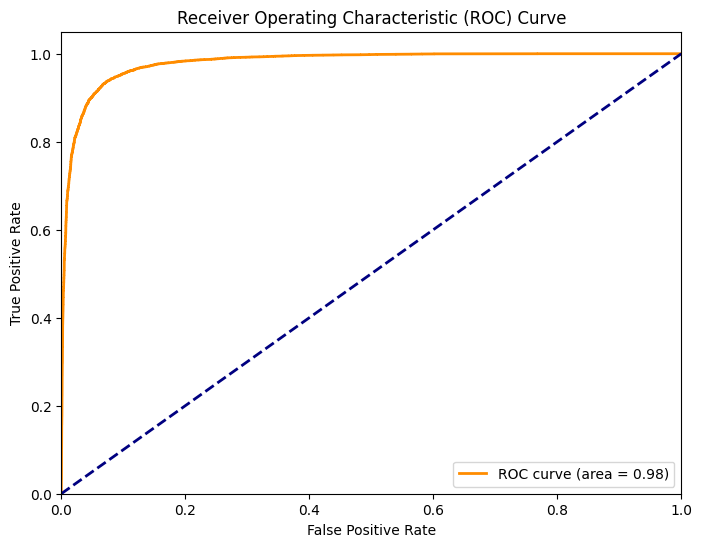

In [16]:
# ROC curve and AUC
from sklearn.metrics import roc_curve, auc

# Get the probabilities for the positive class
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 2nd part - False classifications
Analysis with Local Interpretable Model-agnostic Explanations (LIME)

In [17]:
!pip install lime


In [18]:
#Load the fine-tuned model and tokenizer
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import os
import glob

In [19]:
# Set model to evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [20]:
import torch
import gc
import joblib
from collections import Counter

# Clear GPU memory at the beginning
torch.cuda.empty_cache()

# Create a cache for LIME explanations
lime_cache_file = "lime_cache.pkl"
try:
    lime_cache = joblib.load(lime_cache_file)
    print(f"Loaded {len(lime_cache)} cached explanations")
except:
    lime_cache = {}
    print("Created new LIME explanation cache")

def predict_proba_lime(texts):
    # Always use CPU for LIME predictions
    model_cpu = model.to("cpu")
    
    # Process inputs in smaller batches
    batch_size = 8
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Reduce max_length to save memory
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                         return_tensors="pt", max_length=256)
        
        with torch.no_grad():
            outputs = model_cpu(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.numpy())
    
    return np.vstack(all_probs) if len(all_probs) > 1 else all_probs[0]

# Create LIME explainer with reduced sampling
class_names = ["Negative", "Positive"]
explainer = LimeTextExplainer(class_names=class_names, split_expression='\W+')

# Function to get or compute LIME explanation
def get_or_compute_explanation(idx, num_features=5):
    cache_key = f"{idx}_{num_features}"
    if cache_key in lime_cache:
        return lime_cache[cache_key]
    
    # Get the text
    text = test_df.iloc[idx]['text']
    
    # Generate LIME explanation with reduced samples
    explanation = explainer.explain_instance(
        text,
        predict_proba_lime,
        num_features=min(num_features, len(text.split())),
        num_samples=500,  # Reduced from default 5000
        top_labels=2
    )
    
    # Cache the result
    lime_cache[cache_key] = explanation
    if len(lime_cache) % 5 == 0:  # Save cache periodically
        joblib.dump(lime_cache, lime_cache_file)
    
    return explanation

# Function to analyze a specific misclassified example
def analyze_misclassification(idx, num_features=5):
    # Move model to CPU and clear memory
    model.to("cpu")
    torch.cuda.empty_cache()
    gc.collect()
    
    # Get the text and labels
    text = test_df.iloc[idx]['text']
    true_label = test_df.iloc[idx]['label']
    true_label_name = "Positive" if true_label == 1 else "Negative"
    pred_label = preds[idx]
    pred_label_name = "Positive" if pred_label == 1 else "Negative"
    confidence = predictions.predictions[idx].max()
    positive_score = all_scores[idx]

    # Print the review and prediction information
    print(f"\n{'='*80}")
    print(f"ANALYZING MISCLASSIFIED EXAMPLE #{idx}")
    print(f"{'='*80}")
    print(f"Review: {text[:200]}...")
    print(f"True sentiment: {true_label_name}")
    print(f"Predicted sentiment: {pred_label_name}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Positive score: {positive_score:.4f}")
    print("-" * 80)

    # Get explanation (from cache or compute new)
    explanation = get_or_compute_explanation(idx, num_features)

    # Analyze both classes to understand why the misclassification happened
    for label_id in [0, 1]:  # 0: Negative, 1: Positive
        label_name = class_names[label_id]
        print(f"\nFeature importance for class: {label_name}")

        # Get the words and their weights
        feature_importance = explanation.as_list(label_id)

        # Sort by absolute weight for better visualization
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

        # Text-based visualization instead of matplotlib
        print(f"Top words driving {label_name} prediction:")
        for word, weight in feature_importance[:10]:
            impact = "increasing" if weight > 0 else "decreasing"
            print(f"  • '{word}': {weight:.4f} ({impact} probability)")

    # Identify words in context
    print("\nWords in context:")
    for word, _ in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)[:5]:
        # Simple approach to find word in context (not perfect for subwords)
        lower_text = text.lower()
        word_lower = word.lower()

        start_pos = lower_text.find(word_lower)
        if start_pos != -1:
            # Get some context around the word
            context_start = max(0, start_pos - 50)
            context_end = min(len(text), start_pos + len(word) + 50)

            context = text[context_start:context_end]
            # Highlight the word in the context
            highlighted = context.replace(word, f"**{word}**")
            print(f"  • Context: \"...{highlighted}...\"")

    # Clear memory again
    torch.cuda.empty_cache()
    gc.collect()
    
    return explanation

# Batch processing for misclassifications
def analyze_misclassifications_batch(num_examples=3, batch_size=2):
    indices = np.random.choice(incorrect_indices, min(num_examples, len(incorrect_indices)), replace=False)
    
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_misclassification(idx)
        
        # Clear memory after each batch
        model.to("cpu")
        torch.cuda.empty_cache()
        gc.collect()
        print(f"Completed batch {i//batch_size + 1}/{(len(indices) + batch_size - 1)//batch_size}")

# Function to analyze the most confident misclassifications
def analyze_confident_misclassifications(num_examples=3, batch_size=2):
    if len(incorrect_indices) == 0:
        print("No misclassified examples found.")
        return

    # Get confidences for all incorrect predictions (limit to first 100 to save memory)
    confidences = []
    for idx in incorrect_indices[:100]:
        conf = predictions.predictions[idx].max()
        confidences.append((idx, conf))

    # Sort by confidence (most confident first)
    confidences.sort(key=lambda x: x[1], reverse=True)
    selected_indices = [idx for idx, _ in confidences[:num_examples]]

    # Analyze in batches
    print(f"\n{'='*80}")
    print(f"ANALYZING MOST CONFIDENT MISCLASSIFICATIONS")
    print(f"{'='*80}")

    for i in range(0, len(selected_indices), batch_size):
        batch_indices = selected_indices[i:i+batch_size]
        for idx in batch_indices:
            analyze_misclassification(idx)
        
        # Clear memory after each batch
        torch.cuda.empty_cache()
        gc.collect()

# Function to analyze patterns in misclassifications
def analyze_misclassification_patterns(max_examples=20):
    word_frequency = Counter()
    
    # Limit to avoid memory issues
    for idx in incorrect_indices[:max_examples]:
        text = test_df.iloc[idx]['text']
        # Count words that appear in these examples
        words = set(text.lower().split())  # Using set to count unique words per review
        word_frequency.update(words)
    
    print("\nCommon words in misclassified examples:")
    for word, count in word_frequency.most_common(10):
        if len(word) > 2:  # Skip very short words
            print(f"'{word}': {count}")
    
    # Find potentially problematic words (appear in many misclassifications)
    print("\nPotentially problematic words:")
    for word, count in word_frequency.most_common(50):
        if len(word) > 3 and count > max_examples/3:
            # Sample a few examples containing this word
            examples = []
            for idx in incorrect_indices[:max_examples]:
                text = test_df.iloc[idx]['text'].lower()
                if word in text.split():
                    true_label = "Positive" if test_df.iloc[idx]['label'] == 1 else "Negative"
                    pred_label = "Positive" if preds[idx] == 1 else "Negative"
                    examples.append((true_label, pred_label))
                    if len(examples) >= 3:
                        break
            
            if examples:
                print(f"'{word}': {count} occurrences - Examples: {examples}")

# Run the analysis with improved memory management
print("Starting optimized LIME analysis of misclassified examples...")
analyze_misclassifications_batch(3, batch_size=1)  # Analyze 3 random misclassifications, 1 at a time

print("\nAnalyzing patterns in misclassifications...")
analyze_misclassification_patterns(20)

print("\nAnalyzing the most confident misclassifications...")
analyze_confident_misclassifications(3, batch_size=1)  # Analyze 3 most confident misclassifications, 1 at a time

# Save final cache
joblib.dump(lime_cache, lime_cache_file)
print(f"\nSaved {len(lime_cache)} explanations to cache")

Created new LIME explanation cache
Starting optimized LIME analysis of misclassified examples...

ANALYZING MISCLASSIFIED EXAMPLE #16123
Review: Sorry to disagree with you, but I found the DKC series to be quite engaging. So much so that I invested in the SNES system and my own copies of the games. This is, mind you, almost ten years after the...
True sentiment: Negative
Predicted sentiment: Positive
Confidence: 3.3524
Positive score: 0.9986
--------------------------------------------------------------------------------

Feature importance for class: Negative
Top words driving Negative prediction:
  • 'True': -0.0194 (decreasing probability)
  • 'Sorry': 0.0167 (increasing probability)
  • 'enjoy': -0.0155 (decreasing probability)
  • 'white': -0.0135 (decreasing probability)
  • 'you': -0.0134 (decreasing probability)

Feature importance for class: Positive
Top words driving Positive prediction:
  • 'True': 0.0194 (increasing probability)
  • 'Sorry': -0.0167 (decreasing probability)